In [60]:
import numpy as np
import pandas as pd
import scipy.stats
import scipy.signal
import matplotlib.pyplot as plt

# General Setup

We have a target distribution and we will try to sample from it using Metropolis-Hastings MCMC with MALA proposal technqiues using various proposal distributions.

Some useful links were found here:  
https://en.wikipedia.org/wiki/Metropolis-adjusted_Langevin_algorithm  
http://www.mcmchandbook.net/HandbookChapter1.pdf  
https://theclevermachine.wordpress.com/2012/11/19/a-gentle-introduction-to-markov-chain-monte-carlo-mcmc/  

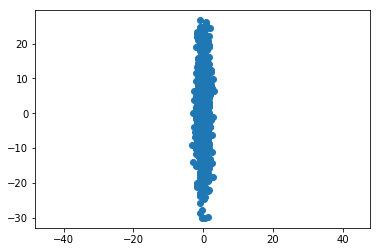

In [61]:
# Target Distribution (Stationary Distribution of the Markov Chain)
# Stretched Normal Distribution in 2D
mean = [0, 0]
cov = [[1, 0], [0, 100]]

target_dist = scipy.stats.multivariate_normal(mean, cov)
data = target_dist.rvs(1000)
df = pd.DataFrame(data, columns=["x", "y"])
plt.plot(df.x, df.y, 'o')
plt.axis('equal')
plt.show()

In [62]:
# Random Walk MCMC Function
def metropolis_step(state, proposal_func, target_logpdf, trans_prob):
    proposed_state = proposal_func(state, target_logpdf)
    
    alpha = (target_logpdf(proposed_state) + np.log(trans_prob(proposed_state, state, target_logpdf)) - 
             target_logpdf(state) - np.log(trans_prob(state, proposed_state, target_logpdf)))
    acceptance_prob = min([0, alpha])
    
    if np.log(np.random.rand()) < acceptance_prob:
        return proposed_state
    else:
        return state
    
# Acceptance rate at every step
def acceptance_rate_per_step(states):
    states = np.asarray(states)
    steps = 0
    accepted = 0
    acc_rate = []
    for i in range(1,len(states)):
        steps += 1
        if (np.isclose(states[i,0], states[i-1,0], rtol=1e-10, atol=1e-15) and 
            np.isclose(states[i,1], states[i-1,1], rtol=1e-10, atol=1e-15)):
            accepted += 1
        acc_rate.append(accepted/steps)
    return acc_rate

## MALA Proposal

We propose by suggesting the state plus the gradient of the target distribution at the state plus a small random motion.

Note, for reference, the derivate with respect to the state of our target distribution is given by:
\begin{equation}
    \frac{\partial \pi(\mathbf{x})}{\partial\mathbf{x}}=-\frac{1}{\sqrt{det(2\pi\mathbf{\Sigma})}}exp\left[-\frac{1}{2}(\mathbf{x}-\mathbf{m})^{T}\mathbf{\Sigma}^{-1}(\mathbf{x}-\mathbf{m})\right]\mathbf{\Sigma}^{-1}(\mathbf{x}-\mathbf{m})
\end{equation}

However, this is a bit irrelevant since I am looking for the gradient at the state. I.e. $\nabla\pi(\textbf{x})$ I will do it numerically.

In [63]:
def grad_target_dist(state, target_dist_logpdf, x_step=1e-9, y_step=1e-9):
    loc = [[state + np.asarray([-x_step, y_step]), state + np.asarray([0, y_step]), state + np.asarray([x_step, y_step])], 
           [state + np.asarray([-x_step, 0]), state + np.asarray([0, 0]), state + np.asarray([x_step, 0])],
           [state + np.asarray([-x_step, -y_step]), state + np.asarray([0, -y_step]), state + np.asarray([x_step, -y_step])]]
    pdf = np.array(list(map(target_dist_logpdf, loc)))
    gradpdf = np.gradient(pdf, x_step, y_step)
    return np.asarray([gradpdf[0][1,1], gradpdf[1][1,1]])

def proposal_mala(state, target_dist_logpdf, tau=1):
    return (np.asarray(state) + 
            tau * grad_target_dist(state, target_dist_logpdf) + 
            np.sqrt(2 * tau) * scipy.stats.multivariate_normal([0,0], tau * np.eye(2)).rvs(1))

def cond_prob_mala(from_state, to_state, target_dist_logpdf, tau=1):
    to_state = np.asarray(to_state)
    from_state = np.asarray(from_state)
    return np.exp((-4 * tau)**(-1) * 
                  np.linalg.norm(to_state - from_state - tau * grad_target_dist(from_state, target_dist_logpdf))**2)

In [64]:
# MCMC Execution
states = [np.array([0,0])]
steps = 5000

for i in range(steps):
    states.append(metropolis_step(states[-1], proposal_mala, target_dist.logpdf, cond_prob_mala))
    
states = np.asarray(states)

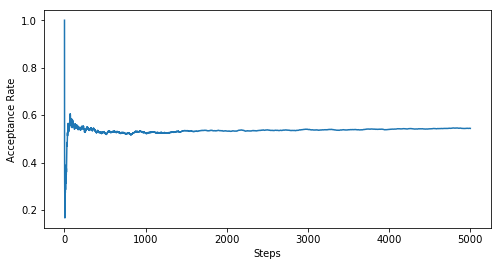

In [65]:
# Acceptance rate plot
acps = acceptance_rate_per_step(states)
plt.figure(figsize=(8, 4))
plt.plot(range(steps), acps)
plt.xlabel('Steps')
plt.ylabel('Acceptance Rate')
plt.show()

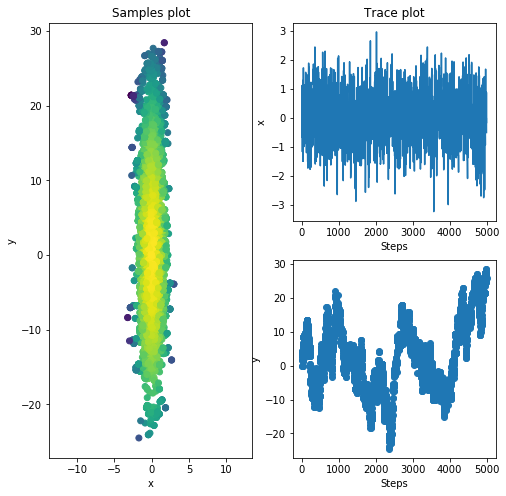

In [66]:
# Sample and trace plots
df = pd.DataFrame(states, columns=["x", "y"])

plt.figure(1, figsize=(8,8))
plt.subplot(121)
plt.scatter(df.x, df.y, c=target_dist.logpdf(states))
plt.axis('equal')
plt.title('Samples plot')
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(222)
plt.plot(np.arange(states.shape[0]), df.x)
plt.title('Trace plot')
plt.xlabel('Steps')
plt.ylabel('x')

plt.subplot(224)
plt.scatter(np.arange(states.shape[0]), df.y)
plt.xlabel('Steps')
plt.ylabel('y')

plt.show()

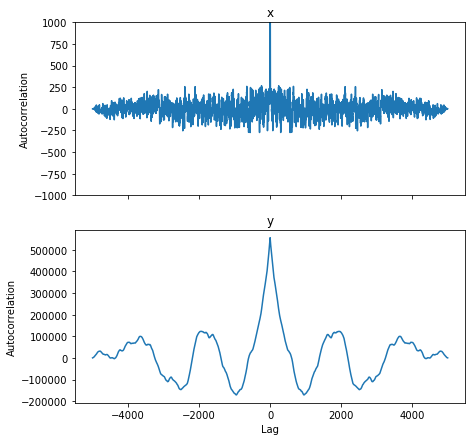

In [67]:
# All lags autocorrelation
autocorx = scipy.signal.correlate(states[:,0], states[:,0])
autocory = scipy.signal.correlate(states[:,1], states[:,1])

fig, (ax_autox, ax_autoy) = plt.subplots(2, 1, sharex=True, figsize=(7,7))

ax_autox.plot(range(-int(autocorx.size/2), int(autocorx.size/2) + 1), autocorx)
ax_autox.set_ylim(-1000,1000)
ax_autox.set_title('x')
ax_autox.set_ylabel('Autocorrelation')

ax_autoy.plot(range(-int(autocory.size/2), int(autocory.size/2) + 1), autocory)
# ax_autoy.set_ylim(-1000,1000)
ax_autoy.set_title('y')
ax_autoy.set_ylabel('Autocorrelation')
ax_autoy.set_xlabel('Lag')
plt.show()